# Nicholas Tam Analysis

## Research Question/Interests
Research question: Given the tree dataset, how would we want to arrange the types of trees to be planted in certain locations, such that they could survive and significantly improve the ecosystem?

Given the research question, it would be ideal to analyze relevant properties, such as the relative sizes of each location and the proportions of planted trees for each species.

The following questions will be used as guidelines to supplement the question:
- Which planted species exist in many different locations within each neighbourhood?
- How do trees that have been planted directly compare in terms of diameter to those that have grown naturally?
- What is the distribution of ages for specific tree species?

## Task Analysis
- Compute: Compute the average percentage differences in `DIAMETER` between planted and non-planted trees, and the ages by the number of days between `DATE_PLANTED` and March 5 2025.
- Filter: Filter out `SPECIES_NAME` such that there are plenty of both planted and non-planted trees.
- Characterise distribution: Find the distribution of ages for planted tree `SPECIES_NAME`?
- Sort: Rank `SPECIES_NAME` for appearing in the greatest number of `NEIGHBOURHOOD_NAME` and having large proportions of each corresponding`ON_STREET` containing them.
- Retrieve value: Retrieve the number of trees that have been planted, separated by `SPECIES_NAME`. 

In [1]:
# !conda install -y altair_saver

In [2]:
import altair as alt
import pandas as pd
from toolz.curried import pipe
import os
from pygbif import species

import sys
sys.path.append("../../code")
sys.path.append("../../images")
import data_clean
import preprocess_query_family
import preprocess_query_pollen
import preprocess_change_col_type
import altair_data_transformer

In [3]:
# Create a new data transformer that stores the files in a directory
data_dir = 'altairdata'
altair_data_transformer.setup_altair_for_large_data(data_dir)

# Set up file path to save images
img_folder = '../../images/ntam_eda1/'

## Data Cleaning
### Initial Dataset
- `TREE_ID`, `CIVIC_NUMBER`, `ON_STREET_BLOCK`, and `HEIGHT_RANGE_ID` are all treated as integers, `DIAMETER` is treated as a float, and the rest are treated as objects.
- `CULTIVAR_NAME`, `NEIGHBOURHOOD_NAME`, and `DATE_PLANTED` are columns that have missing values.
- `public_trees.nunique()` displays the number of unique values for each column. Notably, there is a discrepancy between the number of unique values for `HEIGHT_RANGE_ID` and the number of unique values for `HEIGHT_RANGE`. Since `GENUS_NAME` and `SPECIES_NAME`, along with `ON_STREET` and `ON_STREET_BLOCK`, are related to each other, the number of unique values may be more accurate if they are combined.
- `public_trees.describe()` is used to further display that `TREE_ID`, `CIVIC_NUMBER`, `ON_STREET_BLOCK`, `HEIGHT_RANGE_ID` and `DIAMETER` are all treated as numeric, when only `HEIGHT_RANGE_ID` and `DIAMETER` could be numeric, along with the latitude and longitude from `geo_point_2d`.

In [4]:
public_trees = pd.read_csv("../../data/raw/public-trees.csv", delimiter=";")

In [5]:
display(public_trees.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 181501 entries, 0 to 181500
Data columns (total 17 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   TREE_ID             181501 non-null  int64  
 1   CIVIC_NUMBER        181501 non-null  int64  
 2   STD_STREET          181501 non-null  object 
 3   GENUS_NAME          181501 non-null  object 
 4   SPECIES_NAME        181501 non-null  object 
 5   CULTIVAR_NAME       80725 non-null   object 
 6   COMMON_NAME         181501 non-null  object 
 7   ON_STREET_BLOCK     181501 non-null  int64  
 8   ON_STREET           181501 non-null  object 
 9   NEIGHBOURHOOD_NAME  177573 non-null  object 
 10  STREET_SIDE_NAME    181501 non-null  object 
 11  HEIGHT_RANGE_ID     181501 non-null  int64  
 12  HEIGHT_RANGE        181501 non-null  object 
 13  DIAMETER            181501 non-null  float64
 14  DATE_PLANTED        74159 non-null   object 
 15  Geom                181501 non-nul

None

In [6]:
cols_with_nan = public_trees.columns[public_trees.isna().any()].tolist()
display(cols_with_nan)

['CULTIVAR_NAME', 'NEIGHBOURHOOD_NAME', 'DATE_PLANTED']

In [7]:
display(public_trees.nunique())

TREE_ID               181501
CIVIC_NUMBER            8339
STD_STREET               814
GENUS_NAME               169
SPECIES_NAME             539
CULTIVAR_NAME            607
COMMON_NAME             1297
ON_STREET_BLOCK          189
ON_STREET                822
NEIGHBOURHOOD_NAME        22
STREET_SIDE_NAME           6
HEIGHT_RANGE_ID           11
HEIGHT_RANGE               9
DIAMETER                 490
DATE_PLANTED            4570
Geom                  181372
geo_point_2d          181372
dtype: int64

### Cleaning
- `HEIGHT_RANGE` is set to be an ordinal attribute, with the order provided in `priority_order`.
- `TREE_ID`, `CIVIC_NUMBER`, and `ON_STREET_BLOCK` are set to be categorical attributes.
- Earlier EDA provided `CULTIVAR_NAME`, `NEIGHBOURHOOD_NAME`, `DATE_PLANTED` as having NA values; `CULTIVAR_NAME` is filled with the corresponding `SPECIES_NAME`, `NEIGHBOURHOOD_NAME` has `NA` strings applied instead, and `DATE_PLANTED` is left with `None`.
- The latitude and longitude values were initially joined together in a single coordinate column `geo_point_2d`, and thus are split into new columns `LATITUDE` and `LONGITUDE`.
- The values `9`, `0` and `10` all correspond to `HEIGHT_RANGE == '>90'` and thus `0` and `10` are replaced with value `9`.
- `NOMENCLATURE` is a column derived from combining `GENUS_NAME` and `SPECIES_NAME` into 1 string.
- `ON_ADDRESS` is a column derived from combining `ON_STREET` and `ON_STREET_BLOCK` into 1 string.
- `FAMILY_NAME` is a column derived from using the functions in `code/preprocess_query_family.py`, which uses the `GENUS_NAME` column and `from pygbif import species` to provide the corresponding family of plants.

In [8]:
public_trees_cleaned = data_clean.clean_public_trees(public_trees)

FAMILY_NAME already exists. Overwriting the column.
FAMILY_NAME added/overwritten in CSV.
HAS_POLLEN already exists. Replacing the column.
HAS_POLLEN replaced in the CSV.


### Processed Data
- Upon loading `public_trees_cleaned.csv` in the future, need to set the attribute types for `HEIGHT_RANGE`, `TREE_ID`, `CIVIC_NUMBER`, and `ON_STREET_BLOCK`.

In [9]:
public_trees_cleaned = pd.read_csv("../../data/processed/public_trees_cleaned.csv")
priority_order = ['10-20', '20-30', '30-40', '40-50', '50-60', '60-70', '70-80', '80-90', '>90']
public_trees_cleaned['HEIGHT_RANGE'] = pd.Categorical(public_trees_cleaned['HEIGHT_RANGE'], categories=priority_order, ordered=True)
public_trees_cleaned[['TREE_ID', 'CIVIC_NUMBER', 'ON_STREET_BLOCK']] = public_trees_cleaned[['TREE_ID', 'CIVIC_NUMBER', 'ON_STREET_BLOCK']].astype(str)

public_trees_cleaned.head()

,TREE_ID,CIVIC_NUMBER,STD_STREET,GENUS_NAME,SPECIES_NAME,CULTIVAR_NAME,COMMON_NAME,ON_STREET_BLOCK,ON_STREET,NEIGHBOURHOOD_NAME,...,DIAMETER,DATE_PLANTED,Geom,geo_point_2d,LATITUDE,LONGITUDE,NOMENCLATURE,ON_ADDRESS,FAMILY_NAME,HAS_POLLEN
0,229002,2128,E 54TH AV,FAGUS,SYLVATICA,DAWYCKII,DAWYCK'S BEECH,2100,E 54TH AV,VICTORIA-FRASERVIEW,...,3.0,2014-03-12,"{""coordinates"": [-123.06377300024464, 49.22020...","49.22020099919947, -123.06377300024464",49.220201,-123.063773,FAGUS SYLVATICA,2100 E 54TH AV VICTORIA-FRASERVIEW (EVEN),FAGACEAE,True
1,229005,8443,FREMLIN ST,ACER,TRUNCATUM,PACIFIC SUNSET,PACIFIC SUNSET MAPLE,8400,FREMLIN ST,MARPOLE,...,12.0,2010-11-08,"{""coordinates"": [-123.12751900039063, 49.20967...","49.20967799914094, -123.12751900039063",49.209678,-123.127519,ACER TRUNCATUM,8400 FREMLIN ST MARPOLE (ODD),ACERACEAE,False
2,229013,1407,W 59TH AV,PRUNUS,CERASIFERA,NIGRA,NIGHT PURPLE LEAF PLUM,7400,CARTIER ST,MARPOLE,...,3.0,2010-10-20,"{""coordinates"": [-123.13790199955884, 49.21762...","49.21762499869929, -123.13790199955884",49.217625,-123.137902,PRUNUS CERASIFERA,7400 CARTIER ST MARPOLE (ODD),ROSACEAE,True
3,229015,489,W 2ND AV,PYRUS,CALLERYANA,CHANTICLEER,CHANTICLEER PEAR,400,W 2ND AV,MOUNT PLEASANT,...,3.0,2009-12-10,"{""coordinates"": [-123.11410500027938, 49.26698...","49.26698999931175, -123.11410500027938",49.266990,-123.114105,PYRUS CALLERYANA,400 W 2ND AV MOUNT PLEASANT (MED),ROSACEAE,False
4,229016,489,W 2ND AV,PYRUS,CALLERYANA,CHANTICLEER,CHANTICLEER PEAR,400,W 2ND AV,MOUNT PLEASANT,...,3.0,2009-12-10,"{""coordinates"": [-123.11399200056373, 49.26704...","49.267045998933334, -123.11399200056373",49.267046,-123.113992,PYRUS CALLERYANA,400 W 2ND AV MOUNT PLEASANT (MED),ROSACEAE,False


In [10]:
display(public_trees_cleaned.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 181501 entries, 0 to 181500
Data columns (total 23 columns):
 #   Column              Non-Null Count   Dtype   
---  ------              --------------   -----   
 0   TREE_ID             181501 non-null  object  
 1   CIVIC_NUMBER        181501 non-null  object  
 2   STD_STREET          181501 non-null  object  
 3   GENUS_NAME          181501 non-null  object  
 4   SPECIES_NAME        181501 non-null  object  
 5   CULTIVAR_NAME       181501 non-null  object  
 6   COMMON_NAME         181501 non-null  object  
 7   ON_STREET_BLOCK     181501 non-null  object  
 8   ON_STREET           181501 non-null  object  
 9   NEIGHBOURHOOD_NAME  177573 non-null  object  
 10  STREET_SIDE_NAME    181501 non-null  object  
 11  HEIGHT_RANGE_ID     181501 non-null  int64   
 12  HEIGHT_RANGE        181501 non-null  category
 13  DIAMETER            181501 non-null  float64 
 14  DATE_PLANTED        74159 non-null   object  
 15  Geom             

None

In [11]:
display(public_trees_cleaned.nunique())

TREE_ID               181501
CIVIC_NUMBER            8339
STD_STREET               814
GENUS_NAME               169
SPECIES_NAME             539
CULTIVAR_NAME           1070
COMMON_NAME             1297
ON_STREET_BLOCK          189
ON_STREET                822
NEIGHBOURHOOD_NAME        22
STREET_SIDE_NAME           6
HEIGHT_RANGE_ID            9
HEIGHT_RANGE               9
DIAMETER                 490
DATE_PLANTED            4570
Geom                  181372
geo_point_2d          181372
LATITUDE              181368
LONGITUDE             181365
NOMENCLATURE             701
ON_ADDRESS             19269
FAMILY_NAME               65
HAS_POLLEN                 2
dtype: int64

In [12]:
display(public_trees_cleaned.describe())

,HEIGHT_RANGE_ID,DIAMETER,LATITUDE,LONGITUDE
count,181501.000000,181501.000000,181501.000000,181501.000000
mean,2.997388,12.734885,49.248839,-123.107687
std,1.939766,10.201543,0.022868,0.048919
min,1.000000,0.000000,49.200203,-123.236684
25%,1.000000,4.000000,49.230403,-123.144378
50%,2.000000,10.000000,49.248475,-123.109569
75%,4.000000,18.000000,49.266611,-123.064573
max,9.000000,305.000000,49.312730,-123.023294


In [13]:
cols_with_nan_2 = public_trees_cleaned.columns[public_trees_cleaned.isna().any()].tolist()
display(cols_with_nan_2)

['NEIGHBOURHOOD_NAME', 'DATE_PLANTED']

## EDA 
### 1. Count of each `SPECIES_NAME` that have been planted
- `Planted_Count` for each species is derived by counting the number of rows with `DATE_PLANTED` filled for each tree species.
- `Proportion_Planted` derived from dividing `Planted_Count` by the total number of the given species.
- Would ideally want a reasonably large `Total_Count` value (at least 300) to mitigate the risk of having too few samples of each species to effectively measure and compare characteristics.
- Would also want `Proportion_Planted` to be within certain range of values (between 0.33 and 0.67) to mitigate the possibility that the obtained properties of planted trees are by random chance, and ensure that there are plenty of both planted and non-planted trees to compare against each other.
- Applied log-transform to `Total_Count` to make colored value range easier to interpret.
- Greater values of `Total_Count` generally provide less extreme values of `Proportion_Planted`.

In [14]:
species_planted_count = public_trees_cleaned[public_trees_cleaned['DATE_PLANTED'].notnull()].groupby('SPECIES_NAME').size().reset_index(name='Planted_Count')
species_total_count = public_trees_cleaned.groupby('SPECIES_NAME').size().reset_index(name='Total_Count')
species_summary = species_planted_count.merge(species_total_count, on='SPECIES_NAME')
species_summary['Proportion_Planted'] = species_summary['Planted_Count'] / species_summary['Total_Count']
# species_summary[(species_summary['Total_Count'] >= 300) & (species_summary['Proportion_Planted'] >= 0.33) & (species_summary['Proportion_Planted'] <= 0.67)]

/opt/anaconda3/lib/python3.12/site-packages/altair/utils/core.py:395: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
/opt/anaconda3/lib/python3.12/site-packages/altair/utils/core.py:395: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)


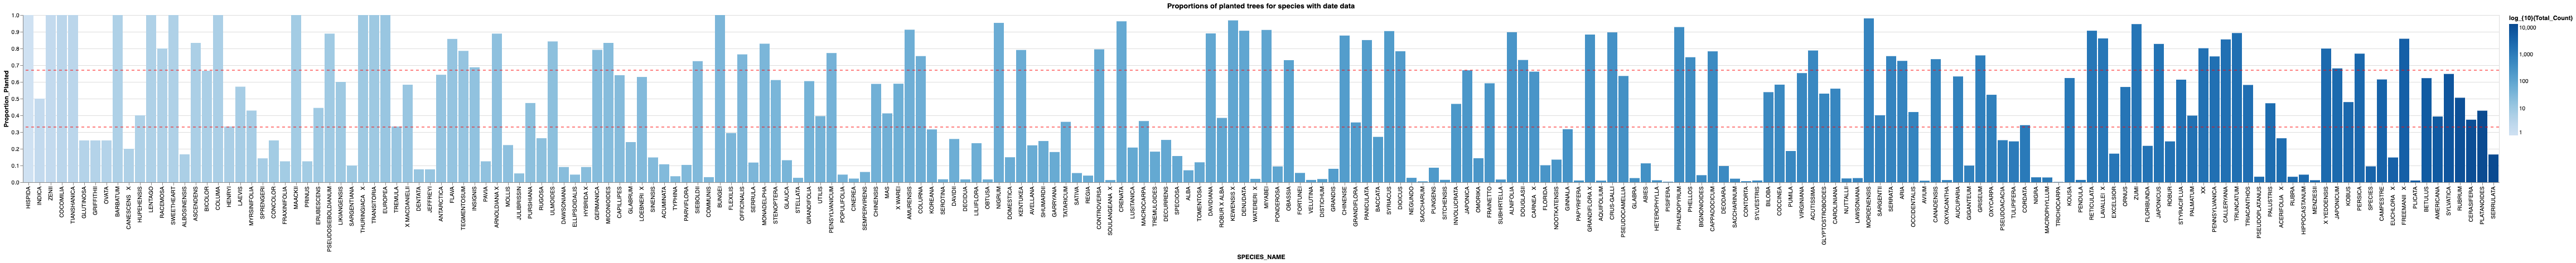

In [15]:
species_chart = alt.Chart(species_summary).mark_bar().encode(
    alt.X('SPECIES_NAME:N', sort='color'),
    alt.Y('Proportion_Planted:Q'),
    alt.Color('Total_Count', scale=alt.Scale(type='log'), title='log_{10}(Total_Count)'),
    alt.Tooltip(['Total_Count']),
).properties(
    title='Proportions of planted trees for species with date data',
)

horizontal_lines = alt.Chart(pd.DataFrame({
    'Proportion_Planted': [0.33, 0.67],
})).mark_rule(color='red', strokeDash=[5, 5]).encode(
    alt.Y('Proportion_Planted:Q'),
)

species_count_chart = species_chart + horizontal_lines
species_count_chart.save(img_folder + 'species_count_chart.png')
display(species_count_chart)

### 2. Scatterplot of `LATITUDE` against `LONGITUDE`
- Distribution of data points along axes of latitude and longitude.
- Provides an estimated "map" of the areas for each `NEIGHBOURHOOD_NAME` in Vancouver, and thus a better understanding of how tree density could be influenced for each area.
- Limited by the number of `NEIGHBOURHOOD_NAME` exceeding the number of colors
- Could be improved upon with `mark_geoshape()`, may require getting coordinate values that were removed in cleaning.

In [16]:
public_trees_cleaned.head()

,TREE_ID,CIVIC_NUMBER,STD_STREET,GENUS_NAME,SPECIES_NAME,CULTIVAR_NAME,COMMON_NAME,ON_STREET_BLOCK,ON_STREET,NEIGHBOURHOOD_NAME,...,DIAMETER,DATE_PLANTED,Geom,geo_point_2d,LATITUDE,LONGITUDE,NOMENCLATURE,ON_ADDRESS,FAMILY_NAME,HAS_POLLEN
0,229002,2128,E 54TH AV,FAGUS,SYLVATICA,DAWYCKII,DAWYCK'S BEECH,2100,E 54TH AV,VICTORIA-FRASERVIEW,...,3.0,2014-03-12,"{""coordinates"": [-123.06377300024464, 49.22020...","49.22020099919947, -123.06377300024464",49.220201,-123.063773,FAGUS SYLVATICA,2100 E 54TH AV VICTORIA-FRASERVIEW (EVEN),FAGACEAE,True
1,229005,8443,FREMLIN ST,ACER,TRUNCATUM,PACIFIC SUNSET,PACIFIC SUNSET MAPLE,8400,FREMLIN ST,MARPOLE,...,12.0,2010-11-08,"{""coordinates"": [-123.12751900039063, 49.20967...","49.20967799914094, -123.12751900039063",49.209678,-123.127519,ACER TRUNCATUM,8400 FREMLIN ST MARPOLE (ODD),ACERACEAE,False
2,229013,1407,W 59TH AV,PRUNUS,CERASIFERA,NIGRA,NIGHT PURPLE LEAF PLUM,7400,CARTIER ST,MARPOLE,...,3.0,2010-10-20,"{""coordinates"": [-123.13790199955884, 49.21762...","49.21762499869929, -123.13790199955884",49.217625,-123.137902,PRUNUS CERASIFERA,7400 CARTIER ST MARPOLE (ODD),ROSACEAE,True
3,229015,489,W 2ND AV,PYRUS,CALLERYANA,CHANTICLEER,CHANTICLEER PEAR,400,W 2ND AV,MOUNT PLEASANT,...,3.0,2009-12-10,"{""coordinates"": [-123.11410500027938, 49.26698...","49.26698999931175, -123.11410500027938",49.266990,-123.114105,PYRUS CALLERYANA,400 W 2ND AV MOUNT PLEASANT (MED),ROSACEAE,False
4,229016,489,W 2ND AV,PYRUS,CALLERYANA,CHANTICLEER,CHANTICLEER PEAR,400,W 2ND AV,MOUNT PLEASANT,...,3.0,2009-12-10,"{""coordinates"": [-123.11399200056373, 49.26704...","49.267045998933334, -123.11399200056373",49.267046,-123.113992,PYRUS CALLERYANA,400 W 2ND AV MOUNT PLEASANT (MED),ROSACEAE,False


/opt/anaconda3/lib/python3.12/site-packages/altair/utils/core.py:395: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
/opt/anaconda3/lib/python3.12/site-packages/altair/utils/core.py:395: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
/opt/anaconda3/lib/python3.12/site-packages/altair/utils/core.py:395: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
/opt/anaconda3/lib/python3.12/site-packages/altair/utils/c

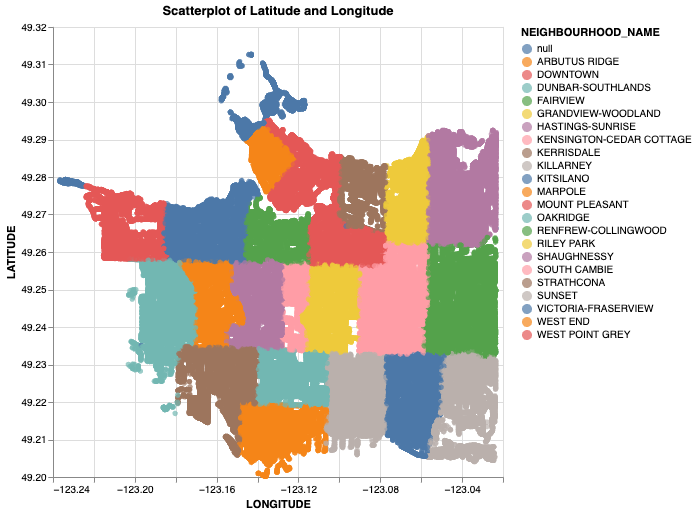

In [17]:
latvlong = alt.Chart(public_trees_cleaned).mark_circle().encode(
    alt.Y('LATITUDE:Q', scale=alt.Scale(zero=False)),
    alt.X('LONGITUDE:Q', scale=alt.Scale(zero=False)),
    alt.Color('NEIGHBOURHOOD_NAME:N'),
    alt.Tooltip(['NEIGHBOURHOOD_NAME']),
).properties(
    title='Scatterplot of Latitude and Longitude',
    width = 450, 
    height = 450
)
latvlong.save(img_folder + 'latvlong.png')
latvlong

### 3. Boxplots of `DIAMETER` grouped by `HEIGHT_RANGE`
- Box plots of `DIAMETER` against `HEIGHT_RANGE`.
- For the most part, mean `DIAMETER` increases with `HEIGHT_RANGE`.
- Outliers for `DIAMETER` appear to be more frequent for lower `HEIGHT_RANGE` values, and less frequent for higher `HEIGHT_RANGE` values.

In [18]:
# public_trees_summary = public_trees_cleaned.groupby("HEIGHT_RANGE")["DIAMETER"].describe()
# upper_bound = max(public_trees_summary["75%"] + public_trees_summary["std"] * 3)
# filtered_data = public_trees_cleaned[public_trees_cleaned["DIAMETER"] <= upper_bound]

/opt/anaconda3/lib/python3.12/site-packages/altair/utils/core.py:395: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
/opt/anaconda3/lib/python3.12/site-packages/altair/utils/core.py:395: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
/opt/anaconda3/lib/python3.12/site-packages/altair/utils/core.py:395: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
/opt/anaconda3/lib/python3.12/site-packages/altair/utils/c

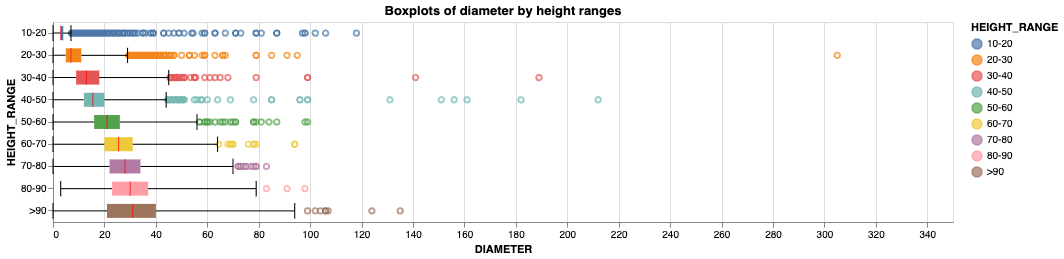

In [19]:
public_trees_box = alt.Chart(public_trees_cleaned).mark_boxplot(
    median={"color": "red"},
    extent=3,
    ticks= True,
).encode(
    # alt.X('DIAMETER:Q', scale=alt.Scale(zero=False, domain=[0, upper_bound + 10])),
    alt.X('DIAMETER:Q', scale=alt.Scale(zero=False)),
    alt.Y('HEIGHT_RANGE:N'),
    alt.Color('HEIGHT_RANGE:N'),
    # alt.Column('HEIGHT_RANGE:N'),
).properties(
    title='Boxplots of diameter by height ranges',
    width = 900, 
    height = 200
)
public_trees_box.save(img_folder + 'public_trees_box.png')
public_trees_box

### 4. Number of `ON_STREET` grouped by `NEIGHBOURHOOD_NAME`
- Number of streets for each neighbourhood.
- Provides idea of potential variety in tree numbers for each location.

/opt/anaconda3/lib/python3.12/site-packages/altair/utils/core.py:395: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
/opt/anaconda3/lib/python3.12/site-packages/altair/utils/core.py:395: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)


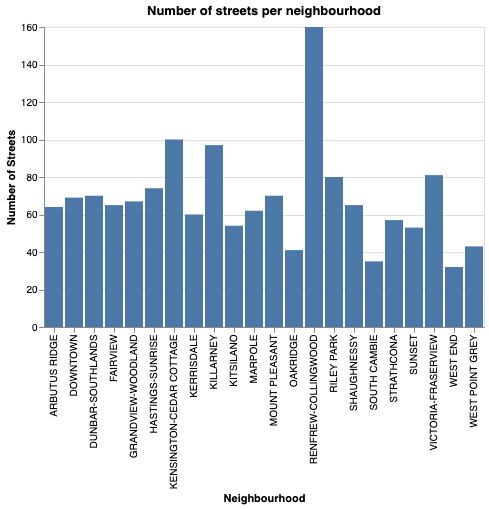

In [20]:
species_per_genus = public_trees_cleaned.groupby('NEIGHBOURHOOD_NAME')['ON_STREET'].nunique().reset_index()

species_per_genus_chart = alt.Chart(species_per_genus).mark_bar().encode(
    alt.X('NEIGHBOURHOOD_NAME:N', title='Neighbourhood'),
    alt.Y('ON_STREET:Q', title='Number of Streets'),
    alt.Tooltip(['NEIGHBOURHOOD_NAME', 'ON_STREET']),
).properties(
    title='Number of streets per neighbourhood',
)
species_per_genus_chart.save(img_folder + 'species_per_genus_chart.png')
species_per_genus_chart

### 5. Proportions of `HEIGHT_RANGE` for each `NEIGHBOURHOOD_NAME`
- Normalized stacked bar plot for `HEIGHT_RANGE` proportions against `NEIGHBOURHOOD_NAME`.
- For the most part, the majority of `HEIGHT_RANGE` values are between `HEIGHT_RANGE == "10-20"` and `HEIGHT_RANGE == "30-40"`.

/var/folders/sp/136d3tf94ns_hpp_7z4mgphm0000gp/T/ipykernel_27217/572338925.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  height_counts = public_trees_cleaned.groupby(['NEIGHBOURHOOD_NAME', 'HEIGHT_RANGE']).size().reset_index(name='Count')
/opt/anaconda3/lib/python3.12/site-packages/altair/utils/core.py:395: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
/opt/anaconda3/lib/python3.12/site-packages/altair/utils/core.py:395: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
 

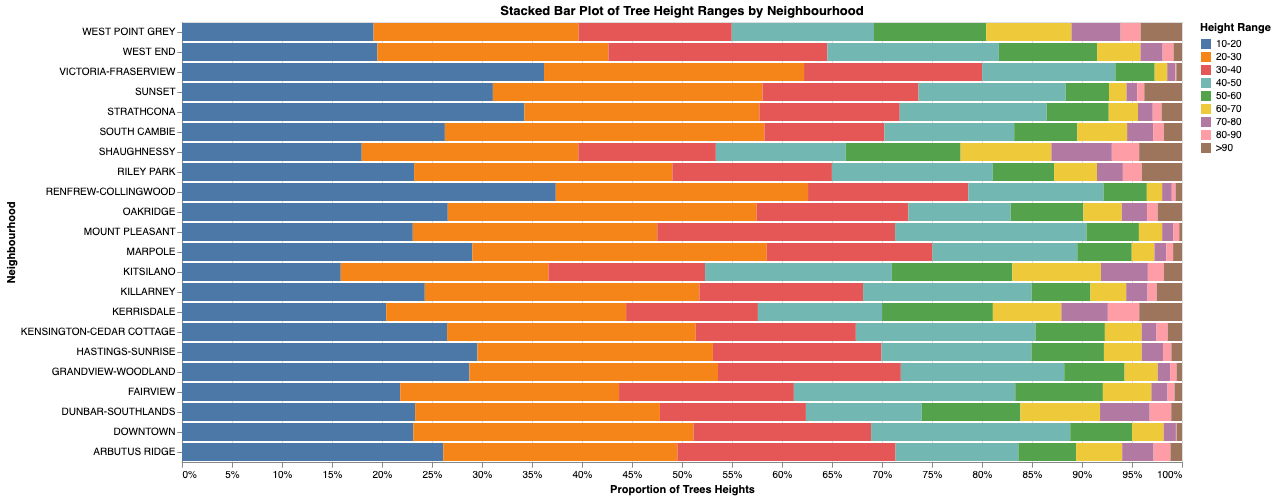

In [21]:
# Aggregate count of trees per neighbourhood and height range
height_counts = public_trees_cleaned.groupby(['NEIGHBOURHOOD_NAME', 'HEIGHT_RANGE']).size().reset_index(name='Count')

# Create the stacked bar chart
neighbour_height_stack = alt.Chart(height_counts).mark_bar().encode(
    alt.Y('NEIGHBOURHOOD_NAME:N', title='Neighbourhood', sort='-y'),  # Sort by count
    alt.X('Count:Q', title='Proportion of Trees Heights', stack='normalize'),
    alt.Color('HEIGHT_RANGE:N', title='Height Range'),  # Custom colors
    alt.Tooltip(['NEIGHBOURHOOD_NAME', 'HEIGHT_RANGE', 'Count']),
).properties(
    title='Stacked Bar Plot of Tree Height Ranges by Neighbourhood',
    width=1000
)
neighbour_height_stack.save(img_folder + 'neighbour_height_stack.png')
neighbour_height_stack

## Sketches

The following sketches assume that `SPECIES_NAME` is filtered such that they follow the rules below:

- A reasonably large `Total_Count` value (at least 300) to mitigate the risk of having too few samples of each species to effectively measure and compare characteristics.
- `Proportion_Planted` to be within certain range of values (between 0.33 and 0.67) to mitigate the possibility that the obtained properties of planted trees are by random chance, and ensure that there are plenty of both planted and non-planted trees to compare against each other.

Sketch 1: Which planted species exist in many different locations within each neighbourhood?

The sketchs are a heatmap, a choropleth, and a set of pie charts, each displaying the proportion of streets within each `NEIGHBOURHOOD_NAME` that have least one instance of `SPECIES_NAME`. These sketches provides an understanding of which species are more common in larger varieties of environments and which species are rarer in comparison.

The high-fidelity sketch expands on the choropleth by allowing zooming into each `NEIGHBOURHOOD_NAME` to display the exact number of planted trees within each street for the given locations. The sketch adheres to the principles of effectiveness, as the channels used are spatial region, color luminance and saturation for the choropleth, and position on an aligned scale and length for the bar plots, allowing for greater accuracy, popout, grouping and discriminability between regions. It also adheres to the Gestalt principle of containment by allowing for zooming to bar plots specific to each `NEIGHBOURHOOD_NAME`.

![sketch_3_1_1](https://github.com/ubc-dsci320-2024w2/project-team_kbn/blob/8325dc3f1027d22f2c41ba572f18fe7956556e24/images/ntam_sketches/sketch_3_1_1.jpg)

![sketch_3_1_2](https://github.com/ubc-dsci320-2024w2/project-team_kbn/blob/8325dc3f1027d22f2c41ba572f18fe7956556e24/images/ntam_sketches/sketch_3_1_2.jpg)

![sketch_3_1_3](https://github.com/ubc-dsci320-2024w2/project-team_kbn/blob/8325dc3f1027d22f2c41ba572f18fe7956556e24/images/ntam_sketches/sketch_3_1_3.jpg)

![hi_sketch_1](https://github.com/ubc-dsci320-2024w2/project-team_kbn/blob/8325dc3f1027d22f2c41ba572f18fe7956556e24/images/ntam_sketches/hi_sketch_1.jpg)

Sketch 2: How do trees that have been planted directly compare in terms of diameter to those that have grown naturally?

The sketches are a bar plot, a dot plot, and a line plot. The first two sketches have `SPECIES_NAME` on the x-axis, and the percentage difference in `DIAMETER` between planted and non-planted `SPECIES_NAME` trees on the y-axis, with non-planted trees as the baseline. The last sketch has the average `DIAMETER` of planted and non-planted trees on the x-axis and y-axis respectively, compared against the `y=x` line. These sketches provides information on how well planted trees fare in terms of growth  compared to non-planted trees, and how effective they are in their current environments.

The high-fidelity sketch expands on the bar plot, by including a tooltip for the average diameters of planted and non-planted trees, as well as a filter for plants by `GENUS_NAME`. The sketch adheres to the principles of effectiveness, as the magnitude channels used are position on an aligned scale and length, allowing for greater accuracy and discriminability. It also adheres to the Gestalt principle of continuity by being arranged in descending order of `DIAM_DIFF_PERCENT`, the percentage difference in diameter between the planted trees and the non-planted trees.

![sketch_3_2_1](https://github.com/ubc-dsci320-2024w2/project-team_kbn/blob/8325dc3f1027d22f2c41ba572f18fe7956556e24/images/ntam_sketches/sketch_3_2_1.jpg)

![sketch_3_2_2](https://github.com/ubc-dsci320-2024w2/project-team_kbn/blob/8325dc3f1027d22f2c41ba572f18fe7956556e24/images/ntam_sketches/sketch_3_2_2.jpg)

![sketch_3_2_3](https://github.com/ubc-dsci320-2024w2/project-team_kbn/blob/8325dc3f1027d22f2c41ba572f18fe7956556e24/images/ntam_sketches/sketch_3_2_3.jpg)

![hi_sketch_2](https://github.com/ubc-dsci320-2024w2/project-team_kbn/blob/8325dc3f1027d22f2c41ba572f18fe7956556e24/images/ntam_sketches/hi_sketch_2.jpg)

Sketch 3: What is the distribution of ages for specific tree species?

The sketches are a density plot, a box plot, and a histogram, all displaying the distribution of age (calculated by the number of days between the planting date and March 5 2025), faceted by `SPECIES_NAME`. These sketches helps with identifying which tree species have longer-standing populations and which ones are relatively newer.

The high-fidelity sketch expands on the density plot, by including a tooltip for the average age and standard deviation for the existing tree ages, as well as a filter for plants by `GENUS_NAME`. The sketch adheres to the principles of effectiveness, as the channels used are area and spatial region, allowing for greater accuracy and grouping between regions. It also adheres to the Gestalt principle of connection, by allowing filtering of density plots by `GENUS_NAME`.

![sketch_3_3_1](https://github.com/ubc-dsci320-2024w2/project-team_kbn/blob/8325dc3f1027d22f2c41ba572f18fe7956556e24/images/ntam_sketches/sketch_3_3_1.jpg)

![sketch_3_3_2](https://github.com/ubc-dsci320-2024w2/project-team_kbn/blob/8325dc3f1027d22f2c41ba572f18fe7956556e24/images/ntam_sketches/sketch_3_3_2.jpg)

![sketch_3_3_3](https://github.com/ubc-dsci320-2024w2/project-team_kbn/blob/8325dc3f1027d22f2c41ba572f18fe7956556e24/images/ntam_sketches/sketch_3_3_3.jpg)

![hi_sketch_3](https://github.com/ubc-dsci320-2024w2/project-team_kbn/blob/8325dc3f1027d22f2c41ba572f18fe7956556e24/images/ntam_sketches/hi_sketch_3.jpg)